In [1]:
import numpy as np
import joblib
import tensorflow as tf
import tensorflow.keras as ks
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
filename = "P:/Datasets/Pickle/DogCat_train"
filename_y = "P:/Datasets/Pickle/DogCat_target"
filename_test = "P:/Datasets/Pickle/DogCat_test"
filename_test_y= "P:/Datasets/Pickle/DogCat_test_target"
X_train = joblib.load(filename)
y_train =joblib.load(filename_y)
X_test = joblib.load(filename_test)
y_test = joblib.load(filename_test_y)
y_train = np.array(y_train)
y_test = np.array(y_test)
X_train.shape,X_test.shape,y_train.shape,y_test.shape


((2000, 100, 100, 3), (10, 100, 100, 3), (2000,), (10,))

In [3]:
class_names = ['cat', 'Dog']

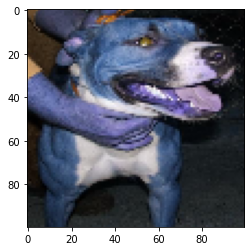

In [4]:
plt.imshow(X_train[0],cmap=plt.cm.gray)
plt.show()

In [6]:
X_train = X_train.reshape(X_train.shape[0],-1).T
y_train =y_train.reshape(y_train.shape[0],-1).T
X_test = X_test.reshape(X_test.shape[0],-1).T
y_test =y_test.reshape(y_test.shape[0],-1).T
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((30000, 2000), (1, 2000), (30000, 10), (1, 10))

In [7]:
# Standardize data to have feature values between 0 and 1.
X_train = X_train/255.
X_test = X_test/255.

In [8]:
X_train.shape, X_test.shape

((30000, 2000), (30000, 10))

 $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$

In [106]:
class Neural_Network:
    
    def __init__(self,layer_dims):
        self.layers=layer_dims
        self.X = None
        self.y = None
        self.m = None
        self.costs = []
        self.lr=None
        self.params={}
        self.activations=[]
        self.L = None
        self.forward_params={}
        self.backward_params={}
        self.activation=[]
        self.lambd = 0
        
    def initialise_weights(self):
        '''Initialise the weigths and bias'''
        for l in range(1,self.L):
            self.params['W'+str(l)] = 0.10*np.random.randn(self.layers[l],self.layers[l-1])
            self.params['b'+str(l)] = np.zeros((self.layers[l],1))
            
    def initialize_parameters_he(self):
        '''Initialise the weigths using he initialization and bias'''
        for l in range(1,self.L):
            self.params['W'+str(l)] = np.random.randn(self.layers[l],self.layers[l-1])*np.sqrt(2./self.layers[l-1])
            self.params['b'+str(l)] = np.zeros((self.layers[l],1))
            

    def relu(self,Z):
        '''Relu Activation Function'''
        return np.maximum(0,Z)
    
    def sigmoid(self,Z):
        '''Sigmoid Activation Function'''
        return (1/(1+np.exp(-Z)))
    
    def sigmoid_backward(self,Z):
        '''Sigmoid Derivative'''
        s = 1/(1+np.exp(-Z))
        dS = s*(1-s)
        return dS
    
    def relu_backward(self,Z):
        '''Relu Derivative'''
        Z[Z<=0] = 0
        Z[Z>0] = 1
        return Z
    
    def linear_forward(self,prev_input, weight, bias):
            z= np.dot(weight,prev_input)+bias
            return z
        
    def activation_forward(self,activation,Z):
        if activation=='sigmoid':
            A = self.sigmoid(Z)
        elif activation == 'relu':
            A = self.relu(Z)
        return A
            
    
    def forward_propogation(self,X):
        '''forward pass'''
        params = self.params
        activation = self.activation
        L = self.L
        Z = X
        for l in range(1,L):
            prev_input = Z
            Z = self.linear_forward(prev_input,params['W'+str(l)],params['b'+str(l)])
            A = self.activation_forward(activation[l-1],Z)
            self.forward_params['Z'+str(l)] = Z
            self.forward_params['A'+str(l)] = A
        y_pred = self.forward_params['A'+str(L-1)]
        return y_pred
                
            
    def compute_cost(self,y,y_pred):
        '''compute the entropy loss'''
        #cost = -1/self.m * (np.sum(np.multiply(np.log(y_pred), y) + np.multiply((1 - y), np.log(1 - y_pred))))
        cost = -1/self.m*np.sum(y*np.log(y_pred) +(1-y)*np.log(1-y_pred))
        return np.squeeze(cost)
    
    def compute_cost_with_reg(self,y,y_pred):
        '''compute the entropy loss'''
        #cost = -1/self.m * (np.sum(np.multiply(np.log(y_pred), y) + np.multiply((1 - y), np.log(1 - y_pred))))
        cross_entropy_cost = -1/self.m*np.sum(y*np.log(y_pred) +(1-y)*np.log(1-y_pred))
        L2_regularization_cost = (1/self.m)*(self.lambd/2)*(np.sum(np.square(self.params['W1']))+np.sum(self.params['W2'])
                                                  +np.sum(np.square(self.params['W3']))+np.sum(np.square(self.params['W4'])))
        cost = cross_entropy_cost+L2_regularization_cost
        return np.squeeze(cost)
    
          
    

    def linear_backward(self,A_prev,dl_Z,W):
        dW = np.dot(dl_Z,A_prev.T)/self.m+(self.lambd/self.m)*W
        db = np.sum(dl_Z,axis=1,keepdims=True)/self.m
        dA = np.dot(W.T,dl_Z)
        return dW,db,dA
    
    def activation_backward(self,Z,activation):
        if activation=='sigmoid':
            dl_act = self.sigmoid_backward(Z)
        elif activation =='relu':
            dl_act = self.relu_backward(Z)
        return dl_act
        
    def backward_propogation(self,y_pred):
        L = self.L
        forward_params = self.forward_params
        params = self.params
        dl_wrt_y_pred = - (np.divide(self.y, y_pred) - np.divide(1 - self.y, 1 - y_pred))
        A = forward_params['A'+str(L-2)]
        dA = dl_wrt_y_pred
        for l in reversed(range(L-1)):
            dl_Z = dA * self.activation_backward(forward_params['Z'+str(l+1)],self.activation[l])
            dW,db,dA = self.linear_backward(A, dl_Z,params['W'+str(l+1)])
            if l==1 or l==0:
                A = self.X
            else:
                A = forward_params['A'+str(l-1)]
            self.backward_params['dW'+str(l+1)] = dW
            self.backward_params['db'+str(l+1)] = db
            self.backward_params['dA'+str(l+1)] = dA
        
    def update_parameters(self):
            L = self.L
            for l in range(1,L):
                self.params['W'+str(l)] = self.params['W'+str(l)] - self.lr*self.backward_params['dW'+str(l)]
                self.params['b'+str(l)] = self.params['b'+str(l)] - self.lr*self.backward_params['db'+str(l)]
        
    def fit(self,X,y,activation,initialize_mode='random',lambd=0,n_iterations=100,learning_rate=0.1,regularization=False):
        self.X = X
        self.y = y
        self.m = X.shape[0]
        self.lr=learning_rate
        self.L =len(self.layers)
        if initialize_mode == 'he':
            self.initialize_parameters_he()
        else:
            self.initialise_weights()
            
        self.activation = activation
        
        for i in range(n_iterations):
            y_pred = self.forward_propogation(self.X)
            if regularization:
                self.lambd = lambd
                cost = self.compute_cost_with_reg(self.y,y_pred)
            else:
                cost = self.compute_cost(self.y,y_pred)
            
            self.backward_propogation(y_pred)
            self.update_parameters()
            self.costs.append(cost)
            if i%10==0:
                 print(f'cost afer {i} iteration is {cost:.2f}')
        
    def predict(self, X):
        '''
        Predicts on a test data
        '''
        pred = self.forward_propogation(X)
        return np.round(pred)              

                                
    def acc(self, y, yhat):
        '''
        Calculates the accuracy between the predicted valuea and the truth labels
        '''
        acc = int(np.sum(y == yhat) / y.shape[1] * 100)
        return acc
        
        

In [111]:
n_x = X_train.shape[0]#784
n_h1 = 64
n_h2 = 32
n_h3 = 16
n_y=y_train.shape[0]#1
layer_dims = [n_x,n_h1,n_h2,n_h3,n_y]
layer_dims

[30000, 64, 32, 16, 1]

In [112]:
activations = ['relu','relu','relu','sigmoid']
model = Neural_Network(layer_dims)
model.fit(X_train,y_train,activations,initialize_mode='random',n_iterations=50,learning_rate=0.001)
y_pred = model.predict(X_test)
acc = model.acc(y_test,y_pred)
acc

cost afer 0 iteration is 0.05
cost afer 10 iteration is 0.05
cost afer 20 iteration is 0.05
cost afer 30 iteration is 0.05
cost afer 40 iteration is 0.05


80

In [72]:
y_pred

array([[0., 1., 0., 1., 1., 1., 1., 1., 1., 0.]])

In [73]:
y_test

array([[0, 1, 0, 1, 1, 0, 1, 1, 0, 0]])

Model using 'he' initialization

In [114]:
activations = ['relu','relu','relu','sigmoid']
model_he = Neural_Network(layer_dims)
model_he.fit(X_train,y_train,activations,initialize_mode='he',n_iterations=50,learning_rate=0.001)
y_pred_he = model_he.predict(X_test)
acc_he = model_he.acc(y_test,y_pred_he)
acc_he

cost afer 0 iteration is 0.06
cost afer 10 iteration is 0.06
cost afer 20 iteration is 0.06
cost afer 30 iteration is 0.06
cost afer 40 iteration is 0.06


40


## 2 - L2 Regularization
The standard way to avoid overfitting is called L2 regularization. It consists of appropriately modifying your cost function, from: $$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} \tag{1}$$ To: $$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} \tag{2}$$

The changes only concern dW1, dW2 and dW3. For each, you have to add the regularization term's gradient ($\frac{d}{dW} ( \frac{1}{2}\frac{\lambda}{m}  W^2) = \frac{\lambda}{m} W$).

In [115]:
activations = ['relu','relu','relu','sigmoid']
model_reg = Neural_Network(layer_dims)
model_reg.fit(X_train,y_train,activations,lambd=0.7,initialize_mode='he',n_iterations=20,learning_rate=0.001,regularization=True)
y_pred_reg = model_reg.predict(X_test)
acc_reg = model_reg.acc(y_test,y_pred_reg)
acc_reg

cost afer 0 iteration is 0.07
cost afer 10 iteration is 0.06


50